In [1]:
import os
import numpy
from datetime import date
import subprocess
import sys  
import operator
import random
import re

#!{sys.executable} -m pip install --user biopython
#!{sys.executable} -m pip install --user ete3

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.axes as axes
import matplotlib.pyplot as plt
from itertools import combinations

from IPython.display import display, clear_output

import ete3
from ete3 import NCBITaxa
ncbi = NCBITaxa()

from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML

from Bio import SeqIO
from Bio import Entrez
Entrez.email = "parsonsc@mit.edu"
Entrez.api_key = "7a3fcee8ce251bc6a20619259badbd6f0e09"

In [7]:
def fastaToDictionary(alignmentName):
    alignFile = open(alignmentName)
    alines = alignFile.readlines()
    alignFile.close

    seqDict = {}
    cur = ""

    for line in alines:
        l = line.strip()
        if l == '':
            continue
        if l[0] == '>':
            cur = l[1:]
            seqDict[cur] = ""
        else:
            if cur not in seqDict:
                print(alignmentName)
            seqDict[cur] += l

    return seqDict

def makeShell(name, commands, nodes='1', cores='1', mem='10', days='7', out=None):
    if out == None:
        out = name
    file = open(name + '.sh', 'w')
    file.write( "#!/bin/bash\n\n"
                "#SBATCH -p sched_mit_g4nier\n"                                                                          
                "#SBATCH -t " + days + "-00:00:00\n"
                "#SBATCH -N " + nodes + "\n"
                "#SBATCH -n " + cores + "\n"
                "#SBATCH --mem=" + mem + "G\n"
                "#SBATCH -J " + name + "\n"
                "#SBATCH -o " + out + ".out\n" +
                '\n'.join(commands))
    file.close()
    return name + '.sh'

def removeRedundancy(fileName):
    f = open(fileName)
    lines = [x.strip() for x in f.readlines()]
    f.close()
    
    seqDict = {}
    
    cur = ''
    running = ''
    for line in lines:
        if line[0] == '>':
            if cur != '':
                if running not in seqDict.values():
                    seqDict[cur] = running
            cur = line[1:]
            running = ''
        else:
            running += line
    if running not in seqDict.values():
        seqDict[cur] = running
    
    out = open(filename, 'w')
    for seq in seqDict:
        out.write(seq + '\n' + seqDict[seq] + '\n')
    out.close()
        
def getSis(node):
    if node.is_root():
        return False
    else:
        return [x for x in node.up.children if x != node][0]
    
def getClade(node):
    leaves = node.get_leaves()
    oneEx = leaves[0].name[0]
    if all(x.name[0] == oneEx for x in leaves):
        return oneEx
    else:
        return None
        
# MAD file generated with -tf flag
def addMADtoTree(treeFile, rootedTreeFile):
    f = open(treeFile)
    treeLine = f.readlines()[0]
    f.close()
    rf = open(rootedTreeFile)
    rTreeLine = rf.readlines()[2][19:].replace(",ADS=", "comADS=").replace(",STT=", "comSTT=").split("[&ADS=\"AI")[0] + ";"
    rf.close()

    tree = ete3.Tree(treeLine, format=1)
    rTree = ete3.Tree(rTreeLine, format=1)
    if len(rTree.children[0]) == 1:
        rTree = rTree.children[1]
    else:
        rTree = rTree.children[0]
    rTreeOg = rTree.children[0]
    if len(rTreeOg) == 1:
        rTreeOg = rTree.children[1]
    for leaf in rTree.get_leaves():
        leaf.add_feature("label", "[" + leaf.name.split("[")[1])
        leaf.name = leaf.name.split("[")[0]
    ogNames = [x.name for x in rTreeOg.get_leaves()]
    for leaf in tree.get_leaves():
        if leaf.name not in ogNames:
            tree.set_outgroup(leaf)
            break
    treeOg = tree.get_common_ancestor(ogNames)
    
    tree.set_outgroup(treeOg)
    treeNodes = list(tree.traverse())
    rTreeNodes = list(rTree.traverse())
    
    for node in tree.traverse():
        leafNames = [x.name for x in node.get_leaves()]
        if len(node) == 1:
            rNode = rTree&leafNames[0]
            adVal = rNode.label.split("com")[0].split("=")[-1]
            adsVal = rNode.label.split("com")[1].split("=")[-1]
        else:
            rNode = rTree.get_common_ancestor(leafNames)
            adVal = rNode.name.split("com")[0].split("=")[-1]
            adsVal = rNode.name.split("com")[1].split("=")[-1]
        if len(rNode) != len(node):
            print("Something wrong lol", len(rNode), len(node))
        node.add_features(AD=adVal, ADS=adsVal)
    return tree


In [2]:
# Download 16 animal (and choanoflagellate) proteomes
taxOfInterest = [946362, 400682, 10228, 45264, 7668, 
                 10224, 7741, 7719, 10090, 6412,
                 6565, 7574, 6198, 37621, 31234,
                 618395]
taxOfInterest = [str(x) for x in taxOfInterest]

"""
handle = Entrez.efetch(db="Taxonomy", id=','.join(taxOfInterest), retmode="xml")
records = Entrez.read(handle)
labels = []
"""
batch_size = 300
for tax in taxOfInterest:
    if tax + '.fasta' in os.listdir("proteomes"):
        continue
    handle = Entrez.esearch(db="protein", term="(txid" + tax + 
                            "[Organism:exp] AND refseq[filters]) NOT mitochondrion", 
                            idtype="acc", retmax=1, usehistory="y")
    search_results = Entrez.read(handle)
    webenv = search_results["WebEnv"]
    query_key = search_results["QueryKey"]
    count = int(search_results["Count"])
    handle.close()
    
    out = open("proteomes/" + tax + ".fasta", 'w')
    print(tax)
    for start in range(0, count, batch_size):
        end = min(count, start+batch_size)
        handle = Entrez.efetch(db="protein", rettype="fasta", retmode="text", retstart=start, 
                               retmax=batch_size, webenv=webenv, query_key=query_key)
        out.write(handle.read())
        handle.close()
    out.close()

In [ ]:
# Incorporation of unrepresented animal phyla (to do)
missing = ["Ctenophora", "Xenacoelomorpha", "Chaetognatha", "Bryozoa", "Entoprocta",
"Cycliophora", "Nemertea", "Phoronida", "Gastrotricha", "Gnathostomulida",
"Micrognathozoa", "Rotifera", "Orthonectida", "Dicyemida", "Loricifera", "Kinorhyncha",
"Nematomorpha", "Tardigrada", "Onychophora"]

queryIds = []
for file in [x for x in os.listdir() if x.split['.'][-1] == 'fasta']:
    firstLines = chris.openFastaAsDictionary(file).keys()
    queryIds.append([x.split(' ')[0] for x in firstLines])

for ID in queryIds:
    result_handle = NCBIWWW.qblast("tblastn", "nt", ID, )

In [78]:
# Remove redundancy from each animal proteome and then combine them all
combined = open("combinedProteomes.fasta", 'w')
for file in [x for x in os.listdir("./proteomes/") if x.split('.')[-1] == 'fasta']:
    fileDir = "./proteomes/" + file
    removeRedundancy(fileDir)
    f = open("./proteomes/" + file)
    name = file.split('.')[0]
    lines = f.readlines()
    f.close()
    
    for line in lines:
        if line[0] == '>':
            combined.write('>' + name + '|' + line[1:])
        else:
            combined.write(line)

combined.close()

In [ ]:
# Cluster animal proteins with varying granularity
outputdir = "clusters"
name = "usearch_" + date.today().strftime("%m_%d_%Y")
commands = ["#SBATCH --array=1-9", 
            "mkdir cluster${SLURM_ARRAY_TASK_ID}0",
            "rm cluster${SLURM_ARRAY_TASK_ID}0/*",
            "module add engaging/usearch",
            "usearch8 -cluster_fast combinedProteomes.fasta " +
            "-id 0.${SLURM_ARRAY_TASK_ID} " +
            "-centroids cluster${SLURM_ARRAY_TASK_ID}0/centroids.fasta " + 
            "-clusters cluster${SLURM_ARRAY_TASK_ID}0/c_"]
usearchSh = makeShell(name, commands)#, out= "cluster${SLURM_ARRAY_TASK_ID}0/" + name)
completed = subprocess.run(["sbatch", usearchSh])

In [80]:
# Measure sizes of clusters at different granularities
sizes = {}
tax = {}

for direc in [x for x in os.listdir() if "cluster" in x]:
    print(direc)
    cutoff = direc[7:]
    sizes[cutoff] = {}
    tax[cutoff] = {}
    for file in os.listdir("./" + direc + "/"):
        if file[0:2] != "c_":
            continue
        f = open("./" + direc + "/" + file)
        ids = [x for x in f.readlines() if x[0] == '>']
        taxa = list(set([x.split('|')[0][1:] for x in ids]))
        sizes[cutoff][file] = len(ids)
        tax[cutoff][file] = ','.join(taxa)
        
    out = open("./" + direc + "/sizes.txt", 'w')
    for cluster in sizes[cutoff]:
        out.write(cluster + '\t' + str(sizes[cutoff][cluster]) + '\t' + tax[cutoff][cluster] + '\n')
    out.close()

cluster80
cluster10
cluster90
cluster40
cluster70
cluster20
cluster50
cluster60
cluster30


In [168]:
# Find larges clusters and clusters w/ adequate diversity
sizes = {}
tax = {}

for direc in [x for x in os.listdir() if "cluster" in x]:
    sizeDirec = direc + "/sizes.txt"
    if "sizes.txt" not in os.listdir(direc):
        continue
    file = open(sizeDirec)
    flines = [x.strip() for x in file.readlines()]
    file.close()
    
    cutoff = direc[7:]
    sizes[cutoff] = {}
    tax[cutoff] = {}
    for line in flines:
        parts = line.split()
        if len(parts) != 3:
            continue
        sizes[cutoff][parts[0]] = int(parts[1])
        tax[cutoff][parts[0]] = parts[2]
    
print("Total max sizes:")
for i in range(1, 10):
    cutoff = str(i * 10)
    maxSize = max(sizes[cutoff].values())
    print(cutoff, [(x, maxSize)for x in sizes[cutoff] if sizes[cutoff][x] == maxSize])

goodClusters = {}
print("\nOver 50% taxon rep:")
for i in range(1, 10):
    cutoff = str(i * 10)
    targSize = 8
    good = [x for x in sizes[cutoff] if len(tax[cutoff][x].split(',')) >= targSize]
    print(cutoff, len(good))
    goodClusters[cutoff] = ([x for x in good])

for cutoff in goodClusters:
    out = open("cluster" + cutoff + "/goodClusters.txt", 'w')
    for clust in goodClusters[cutoff]:
        out.write(clust + '\n')

Total max sizes:
10 [('c_80600', 483)]
20 [('c_93434', 476)]
30 [('c_100964', 452)]
40 [('c_111038', 401)]
50 [('c_131840', 215)]
60 [('c_147330', 265)]
70 [('c_160811', 259)]
80 [('c_3122', 158)]
90 [('c_7376', 147)]

Over 50% taxon rep:
10 3810
20 3524
30 3326
40 2784
50 1823
60 914
70 377
80 135
90 24


In [172]:
# Find best hits to the centroid of each cluster using local blast
favCutoff = "40"
reps = open("cluster" + favCutoff + "/centroids.fasta")
repLines = [x.strip() for x in reps.readlines()]
reps.close()

centroidDict = {}
i = -1
for line in repLines:
    if line[0] == '>':
        i += 1
        centroidDict["c_" + str(i)] = ""
    else:
        centroidDict["c_" + str(i)] += line        

out = open("cluster" + favCutoff + "/goodCentroids.fasta", 'w')
for cluster in goodClusters[favCutoff]:
    out.write('>' + cluster + '\n' + centroidDict[cluster] + '\n')
out.close()
        
completed = subprocess.run(["mkdir", "blastHits"])
completed = subprocess.run(["mkdir", "blastHits/cluster" + favCutoff])

numWTargetHits = 0
outputdir = "blastHits/cluster" + favCutoff
name = "blast_" + date.today().strftime("%m_%d_%Y")
print(name)
commands = ["module add engaging/ncbi-blast/2.6.0+",
            "blastp -db nr " +
            "-query cluster" + favCutoff + "/goodCentroids.fasta " +
            "-outfmt \"7 std staxids\" -num_alignments 10000 -evalue 1e-5 " +
            "-out blastHits/cluster" + favCutoff + "/blastHits.txt -num_threads 20"]
blastSh = makeShell(name, commands, cores='20', mem='50', days='20')#, out= "cluster${SLURM_ARRAY_TASK_ID}0/" + name)
completed = subprocess.run(["sbatch", blastSh])

blast_10_29_2019


In [3]:
taxOfInterest = [946362, 400682, 10228, 45264, 7668, 
                 10224, 7741, 7719, 10090, 6412,
                 6565, 7574, 6198, 37621, 31234,
                 618395]
taxOfInterest = [str(x) for x in taxOfInterest]
for node in ncbi.get_topology(taxOfInterest).traverse("levelorder"):
    if node.rank != "species":
        atts = (node.sci_name, len(node.get_leaves()), node.rank, [(x.sci_name, len(x.get_leaves())) for x in node.children])
        print(atts)

('Opisthokonta', 16, 'no rank', [('Metazoa', 15), ('Salpingoeca rosetta', 1)])
('Metazoa', 15, 'kingdom', [('Eumetazoa', 13), ('Trichoplax adhaerens', 1), ('Amphimedon queenslandica', 1)])
('Eumetazoa', 13, 'no rank', [('Bilateria', 12), ('Acropora millepora', 1)])
('Bilateria', 12, 'no rank', [('Protostomia', 6), ('Deuterostomia', 5), ('Opisthorchis viverrini', 1)])
('Protostomia', 6, 'no rank', [('Ecdysozoa', 3), ('Lophotrochozoa', 3)])
('Deuterostomia', 5, 'no rank', [('Chordata', 3), ('Saccoglossus kowalevskii', 1), ('Strongylocentrotus purpuratus', 1)])
('Ecdysozoa', 3, 'no rank', [('Priapulus caudatus', 1), ('Caenorhabditis remanei', 1), ('Prismognathus prossi', 1)])
('Lophotrochozoa', 3, 'no rank', [('Crassostrea virginica', 1), ('Helobdella robusta', 1), ('Lingula anatina', 1)])
('Chordata', 3, 'phylum', [('Branchiostoma belcheri', 1), ('Ciona intestinalis', 1), ('Mus musculus', 1)])


In [4]:
supplement = [6087, 669202, 133434, 307972, 7739,
              34765, 283909, 37653, 400727, 259920,
              8030, 7897, 9031, 194408, 8355,
              70667, 117903, 282301, 10195, 6279,
              34508, 53326, 40348, 6290, 6334,
              6945, 6850, 6689]
supplement = [str(x) for x in supplement]

allTax = taxOfInterest + supplement

for node in ncbi.get_topology(allTax).traverse("levelorder"):
    if node.rank != "species":
        atts = (node.sci_name, len(node.get_leaves()), node.rank, [(x.sci_name, len(x.get_leaves())) for x in node.children])
        print(atts)

('Opisthokonta', 44, 'no rank', [('Metazoa', 43), ('Salpingoeca rosetta', 1)])
('Metazoa', 43, 'kingdom', [('Eumetazoa', 41), ('Trichoplax adhaerens', 1), ('Amphimedon queenslandica', 1)])
('Eumetazoa', 41, 'no rank', [('Bilateria', 38), ('Cnidaria', 3)])
('Bilateria', 38, 'no rank', [('Protostomia', 19), ('Deuterostomia', 15), ('Platyhelminthes', 4)])
('Cnidaria', 3, 'phylum', [('Thelohanellus kitauei', 1), ('Hydra vulgaris', 1), ('Acropora millepora', 1)])
('Protostomia', 19, 'no rank', [('Ecdysozoa', 12), ('Lophotrochozoa', 7)])
('Deuterostomia', 15, 'no rank', [('Chordata', 11), ('Eleutherozoa', 3), ('Saccoglossus kowalevskii', 1)])
('Platyhelminthes', 4, 'phylum', [('Schistocephalus solidus', 1), ('Protopolystoma xenopodis', 1), ('Macrostomum lignano', 1), ('Opisthorchis viverrini', 1)])
('Ecdysozoa', 12, 'no rank', [('Nematoda', 7), ('Arthropoda', 4), ('Priapulus caudatus', 1)])
('Lophotrochozoa', 7, 'no rank', [('Annelida', 2), ('Mollusca', 3), ('Brachionus plicatilis', 1), ('Li

In [5]:
# Pull out all hits that are either bacterial or in my collection of metazoa
# and put them in their own fastas (possibly look at xreadlines to reduce memory usage?)
favCutoff = '40'
evalueThres = 1

blast_results_chunks = pd.read_csv("blastHits/cluster" + favCutoff + "/blastHits.txt", sep='\t', comment='#',
                                   names=["qseq", "sseq", "pident", "length", "mismatch", "gapopen", "qstart",
                                   "qend", "sstart", "send", "evalue", "bitscore", "taxid"], chunksize=1000000)
blast_results = pd.concat([chunk for chunk in blast_results_chunks])

r, c = blast_results.shape

seen = {}
linDict = {}
for i in range(r):
    #if float(blast_results.loc[i]['evalue']) > evalueThres:
        #continue
    if i % 10000 == 0:
        clear_output(wait=True)
        display(str(round(i * 100 / r, 2)) + "% complete.")
    tids = str(blast_results.loc[i]["taxid"]).split(';')
    tid = tids[0]
    lin = linDict.get(tid)
    if lin == None:
        try:
            lin = ncbi.get_lineage(tid)
            if 33208 in lin or 28009 in lin:
                linDict[tid] = 'm'
                lin = 'm'
            elif 2 in lin:
                linDict[tid] = 'b'
                lin = 'b'
            elif 2157 in lin:
                linDict[tid] = 'a'
                lin = 'a'
            elif 2759 in lin:
                linDict[tid] = 'e'
                lin = 'e'
            else:
                print(lin)
                linDict[tid] = 'syn'
                lin = 'syn'
        except:
            linDict[tid] = 'n'
            continue
    elif lin == 'b':
        clust = blast_results.loc[i]["qseq"]
        hit = blast_results.loc[i]["sseq"]
        toAdd = (clust, tids[0], 'b')
        if hit not in seen:
            seen[hit] = [toAdd]
        elif toAdd not in seen[hit]:
            seen[hit].append(toAdd)
    elif lin == 'm':
        matchedTids = [x for x in tids if x in allTax]
        if len(matchedTids) > 0:
            clust = blast_results.loc[i]["qseq"]
            hit = blast_results.loc[i]["sseq"]
            if hit not in seen:
                seen[hit] = []
            for tid in matchedTids:
                toAdd = (clust, tid, 'm')
                if toAdd not in seen[hit]:
                    seen[hit].append((clust, tid, 'm'))
    elif lin != 'syn':
        clust = blast_results.loc[i]["qseq"]
        hit = blast_results.loc[i]["sseq"]
        toAdd = (clust, tids[0], lin)
        if hit not in seen:
            seen[hit] = [toAdd]
        elif toAdd not in seen[hit]:
            seen[hit].append(toAdd)
    
out1 = open("blastHits/cluster" + favCutoff + "/blastHitsNames.txt", 'w')
out2 = open("blastHits/cluster" + favCutoff + "/blastHitsNamesAndClusters.txt", 'w')
for seq in seen:
    clusters = ','.join(list(set([x[0] for x in seen[seq]])))
    tax = ','.join(list(set([x[1] for x in seen[seq]])))
    out1.write(seq + "\n")
    out2.write(seq + "\t" + clusters + "\t" + tax + "\t" + seen[seq][0][2] + "\n")
out1.close()
out2.close()

'99.97% complete.'

In [1]:
# Book-keeping. Exclude clusters with few bacterial hits from downstream analyses.
favCutoff = "40"

f = open("blastHits/cluster" + favCutoff + "/blastHitsNamesAndClusters.txt")
flines = [line.strip() for line in f]
f.close()

clustCounts = {}
clusters = {}
idents = {}
blastTax = {}
rankCounts = {}
"""
linDict = {}
rankDict = {}
nameDict = {}
"""
for line in flines:
    seq, clust, tids, dom = line.split()
    clusts = clust.split(',')
    idents[seq] = dom
    blastTax[seq] = tids
    for c in clusts:
        if c in clusters:
            clusters[c].append(seq)
        else:
            clusters[c] = [seq]
        if dom == 'b':
            if c not in clustCounts:
                clustCounts[c] = 1
            else:
                clustCounts[c] += 1
    """    
    if dom != "b":
        continue
    
    taxid = tids
    lin = linDict.get(taxid)
    if not lin:
        lin = ncbi.get_lineage(taxid)
        linDict[taxid] = lin
    notIn = [x for x in lin if x not in nameDict]
    names = ncbi.get_taxid_translator(notIn)
    ranks = ncbi.get_rank(notIn)
    for name in names:
        nameDict[name] = names[name]
        rankDict[name] = ranks[name]
    lineage = dict([(rankDict[x], nameDict[x]) for x in lin])
    for file in clusts:
        if clustCounts[file] < 501:
            continue
        if file not in rankCounts:
            rankCounts[file] = {}
        for rank in lineage:
            name = lineage[rank]
            if rank in rankCounts[file]:
                if name in rankCounts[file][rank]:
                    rankCounts[file][rank][name] += 1
                else:
                    rankCounts[file][rank][name] = 1
            else:
                rankCounts[file][rank] = {}
                rankCounts[file][rank][name] = 1"""

Number of clusters: 2784
Number of clusters with over 0 bacterial hits: 1984
Number of clusters with over 500 bacterial hits: 966
Number of clusters with between 500 and 2000 bacterial hits: 141


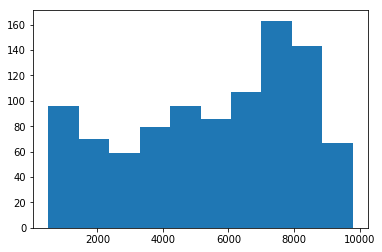

In [5]:
#print("Number of sequences:", len(seen))
print("Number of clusters:", len(clusters))
print("Number of clusters with over 0 bacterial hits:", len(clustCounts))
print("Number of clusters with over 500 bacterial hits:", len([x for x in clustCounts if clustCounts[x] > 500]))
print("Number of clusters with between 500 and 2000 bacterial hits:", 
      len([x for x in clustCounts if clustCounts[x] > 500 and clustCounts[x] < 2000]))

fig = plt.hist([x for x in list(clustCounts.values()) if x > 500])

In [9]:
# Download hits from NCBI
"""
outputdir = "blastHits/cluster" + favCutoff
name = "blastdbcmd_" + date.today().strftime("%m_%d_%Y")
commands = ["module add engaging/ncbi-blast/2.6.0+",
            "blastdbcmd -db nr " +
            "-entry_batch blastHits/cluster" + favCutoff + "/blastHitsNames.txt " +
            "-outfmt \"%f\" -out blastHits/cluster" + favCutoff + "/allBlastHits.fasta"]
blastdbcmdSh = makeShell(name, commands)
completed = subprocess.run(["sbatch", blastdbcmdSh])
"""

favCutoff = "40"
completed = subprocess.run(["mkdir", "blastClusters/"])
completed = subprocess.run(["mkdir", "blastClusters/cluster" + favCutoff])

for clust in clusters:
    if clust not in clustCounts:
        continue
    elif clustCounts[clust] < 500: #or clustCounts[clust] > 1000:
        continue
    filename = clust + ".fasta"
    if filename in os.listdir("blastClusters/cluster" + favCutoff + "/"):
        #print(filename, "already found")
        continue
    
    allSeqIDs = clusters[clust]
    allMetSeqIDs = [x for x in allSeqIDs if idents[x] == 'm']
    mSeqIDs = random.sample(allMetSeqIDs, min(100, len(allMetSeqIDs)))
    allBactSeqIDs = [x for x in allSeqIDs if idents[x] == 'b']
    bSeqIDs = random.sample(allBactSeqIDs, 150)
    allNonSeqIDs = [x for x in allSeqIDs if idents[x] == 'n']
    nSeqIDs = random.sample(allNonSeqIDs, min(50, len(allNonSeqIDs)))
    seqIDs = mSeqIDs + bSeqIDs + nSeqIDs
    
    count = len(seqIDs)
    out = open("blastClusters/cluster" + favCutoff + "/" + filename, 'w')
    batch_size = 500
    for start in range(0, count, batch_size):
        end = min(count, start+batch_size)
        ids = ','.join(seqIDs[start:end])
        try:
            handle = Entrez.efetch(db="protein", rettype="fasta", retmode="text", id=ids)
            out.write(handle.read())
        except:
            continue
        handle.close()
    out.close()

In [57]:
# Figure out the names of the proteins
clustAnnotations = {}
favCutoff = "40"
direc = "blastClusters/cluster" + favCutoff + "/"
#print([x for x in os.listdir(direc) if (x.split('.')[-1] == "fasta" and x[0] == "c")][0])
tooGeneric = ["domain-containingXoXoXprotein", "containingXoXoXprotein", 
              "repeatXoXoXprotein", "hypotheticalXoXoXprotein"]
for file in [x for x in os.listdir(direc) if (x.split('.')[-1] == "fasta" and x[0] == "c")]:
    #print(file)
    f = open(direc + file)
    names = [x for x in f.readlines() if x[0] == ">"]
    f.close()
    wordBag = {}
    for name in names:
        parts = name.split("[")[0].split(":")[-1].split()[1:]
        combos = ["XoXoX".join(parts[x:y]) for x, y in combinations(
                    range(len(parts) + 1), r=2) if len(parts[x:y]) > 1]
        for combo in combos:
            if combo in tooGeneric:
                continue
            if combo in wordBag:
                wordBag[combo] += 1
            else:
                wordBag[combo] = 1
    sortedParts = sorted(wordBag.items(), key=lambda x: x[1])
    sortedParts.reverse()
    bestChances = [x for x in sortedParts if x[1] > sortedParts[0][1] / 2]
    best = ("a", 0)
    for name, num in bestChances:
        numParts = len(name.split("XoXoX"))
        if numParts > best[1]:
            best = (name, numParts)
    clustAnnotations[file.split('.')[0]] = best[0].replace("XoXoX", "_")
    #print(best)
#print(nameDict)

In [14]:
# Rename hits to fit with my ongoing naming structure: "[m or b]|[taxid(s)]|[NCBI sequence ID]"
favCutoff = "40"
direc = "blastClusters/cluster" + favCutoff + "/"
for file in [x for x in os.listdir(direc) if x.split('.')[-1] == "fasta" and x[0] == "c"]:
    dic = fastaToDictionary(direc + file)
    newDic = {}
    for seq in dic:
        seqId = seq.split()[0]
        try:
            dom = idents[seqId]
        except:
            try:
                seqId2 = seqId.split('|')[1]
            except:
                print(seqId)
                continue
            
            dom = idents.get(seqId2)
            if not dom:
                piece2 = seqId.split('|')[-1].split()[0]
                if seqId2 == "":
                    seqId3 = piece2
                else:
                    seqId3 = seqId2 + "_" + piece2
                dom = idents.get(seqId3)
                seqId = seqId3
                if dom == None:
                    print(seq, seqId3)
                    continue
            else:
                seqId = seqId2
        newDic[">" + dom + "|" + blastTax[seqId] + "|" + seqId] = dic[seq]
    out = open(direc + "rn_" + file, 'w')
    for seq in newDic:
        out.write(seq + '\n' + newDic[seq] + '\n')
    out.close()

S72196.1
I49121.1
pdb|6G2J|DD Chain d, NADH dehydrogenase [ubiquinone] 1 subunit C2 6G2J_DD


In [15]:
# Align sequences with MAFFT
favCutoff = '40'
completed = subprocess.run(["mkdir", "alignments"])
completed = subprocess.run(["mkdir", "alignments/cluster" + favCutoff])

fastas = [x.split('.')[0] for x in os.listdir("blastClusters/cluster" + favCutoff) 
          if x.split('.')[-1] == "fasta" and x[0:2] == "rn" and 
          x.replace("fasta","afa") not in os.listdir("alignments/cluster" + favCutoff)]
numReps = len(fastas)
out = open("blastClusters/cluster" + favCutoff + "/clusterList.txt", 'w')
out.write('\n'.join(fastas))
out.close()


names = []
for i in range(1, numReps, 400):
    name = "mafft_" + date.today().strftime("%m_%d_%Y") + "_" + str(int(((i - 1) / 400) + 1))
    names.append(name + ".sh")
    last = min(i + 400, numReps)
    commands = ["#SBATCH --array=" + str(i) + "-" + str(last) + "%" + str(int(min(40, last - i + 1))), 
                "FILENAME=$(awk \"NR==$SLURM_ARRAY_TASK_ID\" blastClusters/cluster" + favCutoff + "/clusterList.txt)",
                "module add engaging/mafft",
                "mafft --localpair --maxiterate 1000 blastClusters/cluster" + favCutoff + 
                "/${FILENAME}.fasta > alignments/cluster" + favCutoff + "/" + "${FILENAME}.afa"]
    mafftSh = makeShell(name, commands, mem = '2')

name = "mafftAll_" + date.today().strftime("%m_%d_%Y")
commands = ["sbatch --wait " + x for x in names]
allMafftSh = makeShell(name, commands, mem = '1')
completed = subprocess.run(["sbatch", allMafftSh])

In [304]:
# Alignment trimming (to do)

In [5]:
# Make trees with IQTree
favCutoff = '40'

completed = subprocess.run(["mkdir", "trees"])
completed = subprocess.run(["mkdir", "trees/cluster" + favCutoff])

alignments = [x.split('.')[0] for x in os.listdir("alignments/cluster" + favCutoff) 
              if x.split('.')[-1] == "afa" and 
              x + ".treefile" not in os.listdir("trees/cluster" + favCutoff)]

numReps = len(alignments)
out = open("alignments/cluster" + favCutoff + "/alignmentList.txt", 'w')
out.write('\n'.join(alignments))
out.close()

names = []
for i in range(1, numReps, 400):
    name = "iqtree_" + date.today().strftime("%m_%d_%Y") + "_" + str(int(((i - 1) / 400) + 1))
    names.append(name + ".sh")
    last = min(i + 400, numReps)
    commands = ["#SBATCH --array=" + str(i) + "-" + str(last) + "%" + str(int(min(30, last - i + 1))), 
                "FILENAME=$(awk \"NR==$SLURM_ARRAY_TASK_ID\" alignments/cluster" + favCutoff + "/alignmentList.txt)",
                "module add engaging/iqtree/1.6.3",
                "iqtree -s alignments/cluster" + favCutoff + "/${FILENAME}.afa " + 
                "-nt 5 -bb 1000 -alrt 1000 -m MFP -mset WAG,LG,JTT -msub nuclear -asr",
                "mv alignments/cluster" + favCutoff + "/${FILENAME}.afa.state /nobackup1b/users/parsonsc/metazoanHgt/trees/cluster" + favCutoff,
                "mv alignments/cluster" + favCutoff + "/${FILENAME}.afa.* trees/cluster" + favCutoff]
    iqtreeSh = makeShell(name, commands, mem = "5", cores="5")

name = "iqtreeAll_" + date.today().strftime("%m_%d_%Y")
commands = ["sbatch --wait " + x for x in names]
allIqtreeSh = makeShell(name, commands, mem = '1')
completed = subprocess.run(["sbatch", allIqtreeSh])

In [49]:
# Root all trees using MAD
favCutoff = "40"
for file in [x for x in os.listdir("trees/cluster" + favCutoff) if x.split('.')[-1] == "treefile"]:
    if file + ".rooted" in os.listdir("trees/cluster" + favCutoff):
        continue
    completed = subprocess.call(['python', '/home/parsonsc/mad/mad.py', '-tf',
                                 'trees/cluster%s/%s' %(favCutoff, file)])
    if completed != 0:
        print(file, completed)

In [50]:
# Load trees
favCutoff = "40"
trees = {}
for file in [x for x in os.listdir("trees/cluster" + favCutoff) if x.split('.')[-1] == "treefile"]:
    #print(file)
    tree = addMADtoTree("trees/cluster%s/%s" %(favCutoff, file), "trees/cluster%s/%s.rooted" %(favCutoff, file))
    if len(tree) > 400:
        print(len(tree), file)
        continue
    for leaf in tree.get_leaves():
        parts = leaf.name.split('_')
        corName = parts[0] + "|" + parts[1] + "|" + '_'.join(parts[2:])
        leaf.name = corName
    trees[file.split('.')[0].replace("rn_", "")] = tree
    
print(len(trees), "trees loaded.")

747 trees loaded.


In [64]:
#print(list(rankCounts.values())[10]["phylum"])
#print(list(list(rankCounts.values())[0].keys()))
allRanks = ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
diversityPlots = {}
incThres = 2
for clust in rankCounts:
    diversityPlots[clust] = [[],[]]
    rankCount = rankCounts[clust]
    for i in range(len(allRanks)):
        rank = allRanks[i]
        if rank not in rankCount:
            numRank = 0
        else:
            uniqueKeys = list(set([x for x in rankCount[rank] if rankCount[rank][x] > incThres]))
            numRank = len(uniqueKeys)
        diversityPlots[clust][0].append(i)
        diversityPlots[clust][1].append(numRank)
        
    f = plt.plot(diversityPlots[clust][0], diversityPlots[clust][1])

In [51]:
# Load trees generated from Hug et al. (2016)
hugFiles = [x for x in os.listdir("hugAlignments") if x.split('.')[-1] == "treefile"]
hugFiles.sort()
for file in hugFiles:
    tree = addMADtoTree("hugAlignments/" + file, "hugAlignments/%s.rooted" %(file))
    trees["h_" + file.split('.')[0]] = tree
    print("h_" + file.split('.')[0])
    for leaf in tree.get_leaves():
        leaf.name = leaf.name[0] + "|" + leaf.name[2:]

print(len(hugFiles), " Hug trees loaded.")

h_L14
h_L15
h_L16
h_L18
h_L2
h_L22
h_L24
h_L3
h_L4
h_L5
h_L6
h_S10
h_S17
h_S19
h_S3
h_S8
16  Hug trees loaded.


In [52]:
dists = {}
normDists = {}
labelledTrees = {}
normFactors = {}
recNames = {}
for file in trees:
    tree = trees[file].copy()
    mAndB = []
    for leaf in tree.get_leaves():
        if leaf.name[0] in ['m', 'b']:
            mAndB.append(leaf)
    print(file)
    tree.prune(mAndB, preserve_branch_length=True)
    
    labelledTrees[file] = tree
    leaves = tree.get_leaves()
    animalRoot = next(x for x in leaves if x.name[0] == 'm')
    tree.set_outgroup(animalRoot)
        
    # Label the easy ones
    for node in tree.traverse():
        if node.is_leaf():
            continue
        else:
            clade = getClade(node)
            node.add_feature("nodeName", node.name.split('/')[0])
            if node.is_root():
                node.name = 'r'
            elif clade:
                node.name = clade
    
    # Loops until all internal nodes are labelled
    while not all(x.name in ['b', 'm', 'u', 'r'] or x.is_leaf() for x in tree.traverse()):
        # Grabs all the already-labelled internal nodes
        toLookAt = [x for x in tree.traverse() if 
                    (x.name in ['b', 'm', 'u']) or x.is_leaf()]
        mut = []
        for node in toLookAt:
            par = node.up
            # If the parent's already labelled, continue
            if par.name in ['b', 'm', 'u', 'r']:
                continue
            
            # If the sister doesn't have a name, continue
            sis = getSis(node)
            if sis.is_leaf():
                sisName = sis.name[0]
            elif sis.name in ['b', 'm', 'u']:
                sisName = sis.name
            else:
                continue
            
            if node.is_leaf():
                nodeName = node.name[0]
            else:
                nodeName = node.name
                
            # If the node and its sister have the same label, give the parent that label
            if nodeName == sisName:
                par.name = nodeName
            # Use the parent's sister to infer parent's label, if node and sister
            # have conflicting labels
            else:
                parSis = getSis(par)
                if parSis.is_leaf():
                    parSisName = parSis.name[0]
                else:
                    parSisName = parSis.name
                # Hopefully parent's sister is labelled
                if parSisName in ['b', 'm', 'u']:
                    # If parent's sister matches one of the parent's children,
                    # parent is assigned that label
                    if parSisName in [nodeName, sisName]:
                        par.name = parSisName
                    # Propagate unknown (e.g ((M,B),U) or ((M,U),B))
                    else:
                        par.name = 'u'
                # If parent's sister is unlabelled, either wait until it is,
                # or recognize that neither can inform each other and label
                # as unknown (e.g. ((M,B),(M,B)))
                else:
                    if [parSis,par] in mut:
                        par.name = 'u'
                        parSis.name = 'u'
                    else:
                        mut.append([par, parSis])
                        
    # Make the OG a bacterial subtree
    for node in [x for x in tree.traverse() if x.name == "b"]:
        if node.up.name == "m":
            tree.set_outgroup(node)
            break
    
    normList = []
    for node in [x for x in tree.traverse() if x.name == "m"]:
        par = node.up
        if par.name not in ["b", "r"]:
            continue
            
        subTree = node.copy()
        #bef = len(subTree)
        subTree.prune([x for x in subTree.get_leaves() if x.name[0] == "m"], preserve_branch_length=True)
        #aft = len(subTree)
        #print(bef, aft)
        kidNames = [x.name.split('|')[1] for x in subTree.get_leaves()]
        
        if len(list(set(kidNames))) < 10:
            continue
        leafBLs = [x.dist for x in subTree.get_leaves() if x.dist > 0.001]
        medBL = np.median(leafBLs)
        good = [x for x in subTree.get_leaves() if x.dist < 3 * medBL]
        #print("Before:", len(subTree), medBL)
        bef = len(subTree)
        subTree.prune(good, preserve_branch_length=True)
        #print("After:", len(subTree))
        aft = len(subTree)
        #print(bef, aft)
        og = subTree.get_midpoint_outgroup()
        subTree.set_outgroup(og)
        leafDists = [subTree.get_distance(x) for x in subTree.get_leaves()]
        normList.append(np.median(leafDists))
    if not normList:
        continue
    normFactors[file] = max(normList)
        
    #if normFactors[file] > 5:
    #    print(file)
    
    #if file[0] == 'h':
    #    print(file, normList)
        
    tree.set_outgroup(animalRoot)
    dists[file] = []
    normDists[file] = []
    recNames[file] = []
    for node in [x for x in tree.traverse() if not (x.is_root() or x.is_leaf())]:
        par = node.up
        if node.name == 'u' or par.name == 'u' or par.name == 'r':
            continue
        kidNames = [x.name.split('|')[1] for x in node.get_leaves()]
        if len(list(set(kidNames))) == 1:
            #print(node)
            continue
        if node.name != par.name:
            recNames[file].append([(node.nodeName, node.name), (par.nodeName, par.name)])
            dists[file].append(node.dist)
            print(node.dist)
            normDists[file].append(node.dist / normFactors[file])
    if dists[file] == []:
        print("Too uncertain:", file)
        dists.pop(file)
        normDists.pop(file)
    #else:
    #    tree.write(format=1,outfile="uhOh2.tree")

c_5460
2.9434983243
c_12063
0.4085161597
c_11462
0.5043718195
c_20400
0.3868492753
c_8344
1.2652740455
c_5505
0.4436215434
c_3419
0.7898286238
0.38370538000000004
c_44045
0.3822504269
c_3436
0.1652861654
c_3281
6.2367354518
c_11839
0.3376173014
1.0192109483
c_11516
0.3038825947
c_6053
1.9404220181
c_5963
2.0048929786
c_12431
0.5009935324
1.1461157574
c_13618
1.5569759728
c_38808
1.0237832947
c_3771
0.9135099583
c_3089
0.3295917901
0.2355226987
0.0254879257
0.1474574979
c_29791
0.2290939895
c_3604
0.6456474122
1.9894057991
c_5807
2.4595075717999997
c_9902
0.2317659364
c_8394
0.6427266877
c_1208
0.2158493558
c_646
0.4792926046
c_96774
1.5927778966
c_3732
0.9053125905
c_13701
Too uncertain: c_13701
c_11258
0.5393252366
0.708295419
c_3992
0.5974182450000001
c_11911
0.3093643636
c_10980
0.556841378
c_33844
0.5464651245
c_23102
0.082808902
1.4304359441
c_1242
0.5586269145
c_4657
1.8241863199
0.6209352242
c_562
0.1367320364
0.4575536904
0.5915987723
c_5541
1.2988814720000001
c_4903
0.66838832

[('h_L14', 0.7536231471), ('h_L15', 0.5490714263), ('h_L16', 1.0401455077), ('h_L18', 0.1981677432), ('h_L2', 0.2970437109), ('h_L22', 0.16173499335000002), ('h_L24', 0.42759087684999997), ('h_L3', 0.58119957005), ('h_L4', 0.47134205885), ('h_L5', 0.6017251506500001), ('h_L6', 0.35457042404999994), ('h_S10', 0.15476407225), ('h_S17', 0.33908489610000003), ('h_S19', 0.18007844360000003), ('h_S3', 0.44903578325000004), ('h_S8', 0.3429802766)]


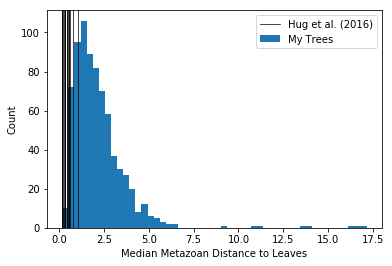

In [53]:
fig = plt.hist([normFactors[x] for x in normFactors if x[0] == "c"], bins=50, label="My Trees")
for xc in [normFactors[x] for x in normFactors if x[0] == "h"]:
    fig = plt.axvline(x=xc, lw = 0.7, color="black")
fig = plt.axvline(x=xc, lw = 0.7, color="black", label="Hug et al. (2016)")
leg = plt.legend()
x = plt.xlabel("Median Metazoan Distance to Leaves")
y = plt.ylabel("Count")
print([(x,normFactors[x]) for x in normFactors if x[0] == "h"])

[(2.3905250063, 'h_L14'), (1.6504758118999998, 'h_L15'), (1.1186650603000001, 'h_L16'), (1.4355006121000002, 'h_L18'), (1.8097017782, 'h_L2'), (3.0804468592000003, 'h_L22'), (2.2369845734, 'h_L24'), (1.7009863387, 'h_L3'), (2.0481433571, 'h_L4'), (2.2115206877, 'h_L5'), (2.1271732161, 'h_L6'), (2.3334634980000004, 'h_S10'), (2.3138070611, 'h_S17'), (1.9182870887999999, 'h_S19'), (2.6322303631, 'h_S3'), (1.5009257258000002, 'h_S8')]


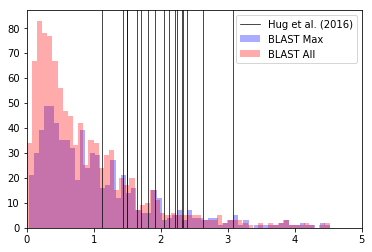

In [60]:
plt.Figure()
blastMax = [max(dists[x]) for x in dists if x[0] == "c"]
fig = plt.hist(blastMax, bins=100, alpha=0.33, color='blue', label="BLAST Max")
blastAll = [y for x in dists for y in dists[x] if x[0] == "c"]
fig = plt.hist(blastAll, bins=100, alpha=0.33, color='red', label="BLAST All")

#print([x for x in dists])
hugLens = [(y, x) for x in dists for y in dists[x] if x[0] != "c"]
print(hugLens)
for xc, name in hugLens:
    #if xc < 2:
        #print(name)
        #continue
    fig = plt.axvline(x=xc, lw = 0.7, color="black")
fig = plt.axvline(x=xc, lw = 0.7, color="black", label="Hug et al. (2016)")
leg = plt.legend()
x = plt.xlim(0,5)
#print([y for x in dists for y in dists[x] if x[0] == "c"])
#print([(x, y) for x in dists for y in dists[x] if x[0] != "c"])
#print([(x, dists[x]) for x in dists if x[0] == "c" and max(dists[x]) < 0.5])


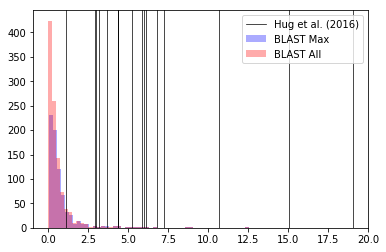

In [55]:
plt.Figure()
blastMax = [max(normDists[x]) for x in normDists if x[0] == "c"]
fig = plt.hist(blastMax, bins=50, alpha=0.33, color='blue', label="BLAST Max")
blastAll = [y for x in normDists for y in normDists[x] if x[0] == "c"]
fig = plt.hist(blastAll, bins=50, alpha=0.33, color='red', label="BLAST All")

#print([x for x in dists])
hugLens = [(y, x) for x in normDists for y in normDists[x] if x[0] != "c"]
#print(hugLens)
for xc, name in hugLens:
    #if xc < 2:
        #print(name)
        #continue
    fig = plt.axvline(x=xc, lw = 0.7, color="black")
fig = plt.axvline(x=xc, lw = 0.7, color="black", label="Hug et al. (2016)")
leg = plt.legend()
#x = plt.xlim(0,4)
#print([y for x in dists for y in dists[x] if x[0] == "c"])
#print([(x, y) for x in dists for y in dists[x] if x[0] != "c"])
#print([(x, dists[x]) for x in dists if x[0] == "c" and max(dists[x]) < 0.5])


[1, 2, 2, 3, 3, 3, 0] c_4472 [0.6289117436564011]

   /-m|282301|PAA52439.1
  |
  |                                    /-m|400727|XP_025088221.1
  |                                 /-|
  |                              /-|   \-m|37653|XP_014772458.1
  |                             |  |
  |                           /-|   \-m|7739|XP_002591894.1
  |                          |  |
  |                        /-|   \-m|6198|OON23391.1
  |                       |  |
  |                       |  |   /-m|6279|XP_001900720.1
  |                     /-|   \-|
  |                    |  |      \-m|6279|CTQ31246.1
  |                  /-|  |
  |                 |  |   \-m|6412|XP_009022883.1
  |                 |  |
  |                 |   \-m|37653|XP_014769280.1
  |                 |
  |                 |         /-m|6290|VDO56273.1
  |                 |        |
  |                 |        |            /-m|8030|XP_014003815.1
  |                 |        |         /-|
  |                 |      

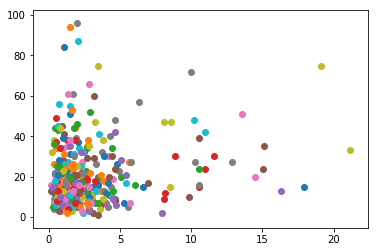

In [543]:
plt.Figure()
inc = []
for clust in diversityPlots:
    ranks, counts = diversityPlots[clust]
    if clust not in dists:
        continue
    else:
        inc.append(clust)
    blastMax = max(dists[clust])
    if 0 in counts:
        print(counts, clust, dists[clust])
        print(trees[clust])
        continue
    f = plt.scatter(blastMax, counts[1])

(329, 7)
(329, 1)
[[ 2.24995809e+00]
 [ 1.35822680e-02]
 [-2.84985751e-02]
 [ 3.73679265e-02]
 [ 2.45548163e-02]
 [-1.38839956e-02]
 [-2.20610891e-03]]


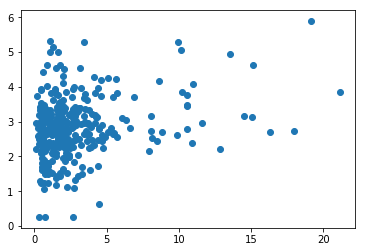

In [526]:
countsAll = [diversityPlots[x][1] for x in inc]
X = np.array(countsAll)
y = np.array([[max(dists[x])] for x in inc])
print(X.shape)
print(y.shape)
th, resids, rank, sing = numpy.linalg.lstsq(X, y, rcond=None)
print(th)
pred = X @ th
f = plt.scatter(y, pred)

In [58]:
# Write all trees to single figtree NEXUS file for visualization
linDict = {}
rankDict = {}
nameDict = {}
favCutoff = "40"
taxLines = []
treeLines = []
maxDists = {}
for file in dists:
    maxDists[file] = max(dists[file])
sorted_trees = sorted(maxDists.items(), key=operator.itemgetter(1))
out = open("trees/cluster" + favCutoff + "/geneNames.txt", 'w')
for file, dist in sorted_trees:
    if file[0] == "h":
        continue
    out.write(file + "," + clustAnnotations[file] + "," + " ".join([str(x) for x in dists[file]]) + "\n")
out.close()
    
for file, dist in sorted_trees:
    if file[0] == "h":
        continue
    tree = trees[file]
    taxTree = tree.copy()
    for node in taxTree.traverse():
        if node.is_leaf():
            parts = node.name.split('|')
            taxid = int(parts[1].split(',')[0])
            gen_spe = nameDict.get(taxid)
            if not gen_spe:
                gen_spe = ncbi.get_taxid_translator([taxid])[taxid]
            taxLine = '\t%s [&gen_spe="%s"' %(node.name, gen_spe)
            
            lin = linDict.get(taxid)
            if not lin:
                lin = ncbi.get_lineage(taxid)
                linDict[taxid] = lin
            notIn = [x for x in lin if x not in nameDict]
            names = ncbi.get_taxid_translator(notIn)
            ranks = ncbi.get_rank(notIn)
            for name in names:
                nameDict[name] = names[name]
                rankDict[name] = ranks[name]
            lineage = dict([(rankDict[x], nameDict[x]) for x in lin])
            for rank in ['class', 'phylum', 'order', 'family']:
                if rank in lineage:
                    taxLine += ' tax_%s="%s"' %(rank, lineage[rank])
            if 33154 in lin:
                if 33213 in lin:
                    if 7711 in lin:
                        dom = "c"
                    else:
                        dom = "b"
                if 28009 in lin or 33208 in lin:
                    dom = "o"
                else:
                    dom = "e"
            elif 2 in lin:
                dom = "b"
            elif 2157 in lin:
                dom = "a"
            elif 2759 in lin:
                dom = "e"
            else:
                dom = "n"
            taxLine += ' group="%s"' %(dom)
            taxLine += ' fullTax="%s"' %'_'.join([nameDict[x] for x in lin])
            taxLine += ']'
            taxLines.append(taxLine)
        else:
            if node.name:
                if '/' in node.name:
                    write_format = 1
                    bits = node.name.split('/')
                    name, aLRT, UFBoot = node.name.split('/')
                    #print(node.AD)
                    node.name = '[&nodeName=%s,UFBoot=%.2f,aLRT=%.2f,AD=%s]' %(name, float(UFBoot), float(aLRT), node.AD)
                    #print(node.name)
                else:
                    write_format = 0
                    node.support = float(node.name)

    newick_text = taxTree.write(format=write_format)
    #print(newick_text)
    if write_format:
        regBit = '_&nodeName_(Node\d+)_UFBoot_(\d+\.\d\d)_aLRT_(\d+\.\d\d)_AD_(\d+\.\d+)_'
        newLab = '[&nodeName=\\1,UFBoot=\\2,aLRT=\\3,AD=\\4]'
        newick_text = re.sub(regBit, newLab, newick_text)
    #print(newick_text)
    treeLines.append("\ttree %s = [&R] %s" %(file, newick_text))

out = open("trees/cluster" + favCutoff + "/tax_trees.figTree", 'w')
out.write("#NEXUS\nbegin taxa;\n\tdimensions ntax=%i;\n\ttaxlabels\n" %len(taxLines))
out.write('\n'.join(taxLines))
out.write(';\nend;\n')
out.write('begin trees;\n%s\nend;' %'\n'.join(treeLines))
out.close()

/home/parsonsc/.local/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 2496114 was translated into 2594914
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 876044 was translated into 2518989
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 1855284 was translated into 1166323
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 310683 was translated into 56812
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/parsonsc/.local/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserW

In [45]:
favCutoff = "40"
header = ['p_A', 'p_R', 'p_N', 'p_D', 'p_C', 'p_Q', 'p_E', 'p_G', 'p_H', 'p_I', 
          'p_L', 'p_K', 'p_M', 'p_F', 'p_P', 'p_S', 'p_T', 'p_W', 'p_Y', 'p_V']

# m to b substitution matrices
subMats = {}

for file in recNames:
    if "h_" == file[0:2]:
        alignFileName = "hugAlignments/" + file[2:] + ".afa"
        statesFileName = alignFileName + ".afa.state"
    else:
        alignFileName = "alignments/cluster%s/rn_%s.afa" %(favCutoff, file)
        statesFileName = "/nobackup1b/users/parsonsc/metazoanHgt/trees/cluster%s/rn_%s.afa.state" %(favCutoff, file)
    alignDict = fastaToDictionary(alignFileName)
    metSeqs = [alignDict[x] for x in alignDict if x[0] == "m"]
    bactSeqs = [alignDict[x] for x in alignDict if x[0] == "b"]
    aLen = len(metSeqs[0])
    siteCounts = [0] * aLen
    for seq in metSeqs + bactSeqs:
        #print(seq)
        for i in range(aLen):
            if seq[i] != "-":
                siteCounts[i] += 1
    totTax = len(metSeqs + bactSeqs)
    #print(totTax)
    goodSites = [(siteCounts[x] / totTax) > 0.5 for x in range(aLen)]
    goodSiteInds = [x for x in range(aLen) if goodSites[x]]
    #print(len(goodSiteInds) / aLen)
    for node1, node2 in recNames[file]:
        if node1[0] == "" or node2[0] == "":
            print(statesFileName, node1, node2)
            continue
        if node1[1] == "m":
            nm, dm = node1
            nb, db = node2
        else:
            nm, dm = node2
            nb, db = node1
        sm = ["-"] * aLen
        sb = ["-"] * aLen
        mm = [[]] * aLen
        mb = [[]] * aLen
        for line in open(statesFileName):
            l = line.strip()
            if l[0] != "N":
                continue
            parts = l.split()
            if parts[0] == nm:
                sm[int(parts[1]) - 1] = parts[2]
                mm[int(parts[1]) - 1] = [float(x) for x in parts[3:]]
            elif parts[0] == nb:
                sb[int(parts[1]) - 1] = parts[2]
                mb[int(parts[1]) - 1] = [float(x) for x in parts[3:]]
        subMat = np.zeros((20, 20))
        sm = "".join(sm)
        sb = "".join(sb)
        for site in goodSiteInds:
            mSite = mm[site]
            bSite = mb[site]
            for i in range(20):
                for j in range(20):
                    try:
                        subMat[i, j] += mSite[i] * mSite[j]
                    except:
                        print(statesFileName, node1, node2,len(mSite), subMat.shape)
                    
        subMats[file] = subMat

/nobackup1b/users/parsonsc/metazoanHgt/trees/cluster40/rn_c_12431.afa.state ('', 'm') ('Node3', 'b')
/nobackup1b/users/parsonsc/metazoanHgt/trees/cluster40/rn_c_3604.afa.state ('', 'm') ('Node15', 'b')
/nobackup1b/users/parsonsc/metazoanHgt/trees/cluster40/rn_c_13745.afa.state ('Node2', 'b') ('', 'm')
/nobackup1b/users/parsonsc/metazoanHgt/trees/cluster40/rn_c_14039.afa.state ('', 'm') ('Node2', 'b')
/nobackup1b/users/parsonsc/metazoanHgt/trees/cluster40/rn_c_24904.afa.state ('Node66', 'b') ('', 'm')
/nobackup1b/users/parsonsc/metazoanHgt/trees/cluster40/rn_c_3896.afa.state ('', 'b') ('', 'm')
/nobackup1b/users/parsonsc/metazoanHgt/trees/cluster40/rn_c_3896.afa.state ('', 'b') ('', 'm')
/nobackup1b/users/parsonsc/metazoanHgt/trees/cluster40/rn_c_3896.afa.state ('', 'm') ('', 'b')
/nobackup1b/users/parsonsc/metazoanHgt/trees/cluster40/rn_c_12510.afa.state ('', 'b') ('', 'm')
/nobackup1b/users/parsonsc/metazoanHgt/trees/cluster40/rn_c_13649.afa.state ('', 'b') ('', 'm')
/nobackup1b/users

FileNotFoundError: [Errno 2] No such file or directory: 'hugAlignments/L14.afa.afa.state'

In [19]:
print(8*[[]])

[[], [], [], [], [], [], [], []]


In [130]:
print("Starting Tree:")
a = ete3.Tree("((a:1,b:1):1,(c:1,d:1):1);")
print(a)
print("BLs:")
for node in list(a.traverse())[1:]:
    print(",".join([x.name for x in node.get_leaves()]), node.dist)

print("\nPrune to a, b, and c with default params:")
a.prune(['a','b','c'])
print(a)
print("BLs:")
for node in list(a.traverse())[1:]:
    print(",".join([x.name for x in node.get_leaves()]), node.dist)

print("\nPrune to a, b, and c with default params, but set preserve_branch_length=True:")
a = ete3.Tree("((a:1,b:1):1,(c:1,d:1):1);")
a.prune(['a','b','c'], preserve_branch_length=True)
print(a)
for node in list(a.traverse())[1:]:
    print(",".join([x.name for x in node.get_leaves()]), node.dist)


Starting Tree:

      /-a
   /-|
  |   \-b
--|
  |   /-c
   \-|
      \-d
BLs:
a,b 1.0
c,d 1.0
a 1.0
b 1.0
c 1.0
d 1.0

Prune to a, b, and c with default params:

      /-a
   /-|
--|   \-b
  |
   \-c
BLs:
a,b 1.0
c 1.0
a 1.0
b 1.0

Prune to a, b, and c with default params, but set preserve_branch_length=True:

      /-a
   /-|
--|   \-b
  |
   \-c
a,b 1.0
c 2.0
a 1.0
b 1.0


In [18]:
# Make a good tree
favCutoff = "40"
f = open("blastHits/cluster" + favCutoff + "/blastHitsNamesAndClusters.txt")
flines = [line.strip() for line in f]
f.close()

clusters = {}
for line in flines:
    seq, clust, tids, dom = line.split()
    clusts = clust.split(',')
    for c in clusts:
        if c in clusters:
            clusters[c].append(seq)
        else:
            clusters[c] = [seq]


def makeAlignment(clusterName):
    completed = subprocess.run(["mkdir", "fullTrees/"])
    completed = subprocess.run(["mkdir", "fullTrees/cluster" + favCutoff])
    
    
    filename = clusterName + ".fasta"
    
    seqIDs = clusters[clust]
    
    """count = len(seqIDs)
    out = open("fullTrees/cluster" + favCutoff + "/" + filename, 'w')
    batch_size = 500
    for start in range(0, count, batch_size):
        end = min(count, start+batch_size)
        ids = ','.join(seqIDs[start:end])
        try:
            handle = Entrez.efetch(db="protein", rettype="fasta", retmode="text", id=ids)
            out.write(handle.read())
        except:
            continue
        handle.close()
    out.close()
    
    print(count, "sequences downloaded.")"""
    
    name = "mafft_" + date.today().strftime("%m_%d_%Y") + "_" + clusterName
    commands = ["module add engaging/mafft",
                "mafft --localpair --maxiterate 1000 fullTrees/cluster" + favCutoff + 
                "/" + filename + " > alignments/cluster" + favCutoff + "/" + clusterName + ".afa"]
    mafftSh = makeShell(name, commands, mem = '10')
    print(mafftSh)

    completed = subprocess.run(["sbatch",  "--wait",  mafftSh])
    
def makeFullTree(clusterName):
    alignmentName = "fullTrees/cluster" + favCutoff + "/" + clusterName + ".afa"
    name = "iqtree_" + date.today().strftime("%m_%d_%Y") + "_" + clusterName

In [ ]:
makeAlignment("c_1312")

mafft_11_22_2020_c_1312.sh
